In [1]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
pd.set_option('display.max_rows', 10)

%load_ext autoreload
%autoreload 2

# Potential impact of post-exposure prophalaxis for COVID-19 with monoclonal antibodies

Updated from March 2021 analysis to include more recent confirmed cases, and also vaccination coverage.

Also updated to use completed, and now peer-reviewed, results from RCT

And in this version, use the KFF survey results that 77% of unvaccinated adults say everyone in their household is unvaccinated. https://www.kff.org/coronavirus-covid-19/poll-finding/kff-covid-19-vaccine-monitor-june-2021/

In [2]:
# range of values to consider in alternative scenarios
coverage_levels = [0, 1/4, 1/2, 3/4, 1]
age_lower_bounds = [0, 20, 40, 50, 60, 70, 80]

In [3]:
n_draws = 100 # number of bootstrap resamples for quantifying uncertainty
np.random.seed(12345)  # set random seed for reproducibility

In [4]:
attack_rate_without_mAbs = np.random.binomial(752, 59/752, size=n_draws) / 752
attack_rate_with_mAbs = np.random.binomial(753, 11/753, size=n_draws) / 753

mAbs_unit_cost = np.random.normal(1_250, 125, size=n_draws)  # 1_250 is what it says online;
COVID_hospitalization_unit_cost = np.random.normal(73_300, 7_330, size=n_draws)

In [5]:
%%time

# Administrated data on how many vaccines have been given in the US
url = "https://data.cdc.gov/api/views/rh2h-3yt2/rows.csv?accessType=DOWNLOAD"
vax_dt = pd.read_csv(url)
#vax_dt

CPU times: user 112 ms, sys: 80 ms, total: 192 ms
Wall time: 9.69 s


In [82]:
total_vax = vax_dt[(vax_dt["Date"] == "05/31/2021") & (vax_dt["date_type"] == "Report") & (vax_dt["Location"] == "US")]
us_pop = 332_378_911 #census population on 5/31/2021 (https://www.census.gov/popclock/)
total_vax.Admin_Dose_1_Cumulative, us_pop, total_vax.Admin_Dose_1_Cumulative / us_pop

(8373    168227462
 Name: Admin_Dose_1_Cumulative, dtype: int64,
 332378911,
 8373    0.506132
 Name: Admin_Dose_1_Cumulative, dtype: float64)

In [83]:
p_vax   = np.random.binomial(us_pop, total_vax.Admin_Dose_1_Cumulative/us_pop, size=n_draws) / us_pop
p_unvax = 1-p_vax
p_vax, p_unvax

(array([0.50611796, 0.50615438, 0.50615595, 0.50611718, 0.50608861,
        0.50613002, 0.50613043, 0.50612521, 0.50608932, 0.50608616,
        0.50612273, 0.50609585, 0.50616302, 0.50612666, 0.50608392,
        0.50616811, 0.5061028 , 0.50614952, 0.50616309, 0.50614193,
        0.50611043, 0.50611978, 0.50612062, 0.50608479, 0.50615139,
        0.50614443, 0.50613256, 0.5061528 , 0.5061249 , 0.50614571,
        0.5061415 , 0.50606175, 0.50606139, 0.5061724 , 0.50616999,
        0.50611828, 0.50616244, 0.50613945, 0.50618072, 0.50613085,
        0.50618001, 0.50612874, 0.50612873, 0.50617495, 0.5061176 ,
        0.5061938 , 0.50613015, 0.50612102, 0.50605971, 0.50610882,
        0.50613068, 0.50615213, 0.50616372, 0.50614277, 0.5061081 ,
        0.5061245 , 0.50613112, 0.50610372, 0.50614251, 0.50610694,
        0.5061399 , 0.50616583, 0.50612794, 0.50612851, 0.50615872,
        0.50612409, 0.5060731 , 0.5060842 , 0.50613851, 0.50611338,
        0.50615739, 0.50613118, 0.50613227, 0.50

In [79]:
# TODO: fill in the following with an appropriate RCT (or meta-analysis, or real-world effectiveness study...)
# numbers from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8022879/pdf/mm7013e3.pdf
n_treated = 2_928 #(excluded 33 cases in study because occured before 14 days period)
cases_treated = 11

n_control = 989
cases_control = 161

efficacy = 1 - (
    (np.random.binomial(n_treated, cases_treated/n_treated, size=n_draws) / n_treated)
    /
    (np.random.binomial(n_control, cases_control/n_control, size=n_draws) / n_control))

## equ1: p_cc = (p_cc_vax*p_vax) + (p_cc_unvax*p_unvax)
## equ2: p_unvax_cc = (p_cc_unvax * p_unvax)/p_cc
## equ3: p_cc_vax = efficacy * p_cc_unvax

## substitute equ3 into equ1: p_cc = ((efficacy * p_cc_unvax) * p_vax) + (p_cc_unvax*p_unvax)
## p_cc = p_cc_unvax((efficacy * p_vax) + p_unvax)

## substitute equ1 into equ2: p_unvax_cc = (p_cc_unvax * p_unvax) / p_cc_unvax((efficacy * p_vax) + p_unvax)
p_unvax_cc =  p_unvax / (((1-efficacy) * (p_vax)) + p_unvax)
p_unvax_cc.mean()

0.977368620064201

In [8]:
pr_unvaccinated_cond_on_test_positive = p_unvax_cc  # np.random.binomial(10_000, unvac_covPos, size=n_draws)/10_000 

# https://files.kff.org/attachment/Topline-KFF-COVID-19-Vaccine-Monitor-June-2021.pdf
# n = 458, p_all_hh_members unvaccinated = 0.69
pr_case_in_unvaccinated_household = pr_unvaccinated_cond_on_test_positive * np.random.binomial(458, 0.69, size=n_draws) / 458

In [9]:
%%time

df_cdc = pd.read_csv('data/cdc_covid_linelist_may_2021.csv.bz2', low_memory=False)

CPU times: user 1.42 s, sys: 56 ms, total: 1.48 s
Wall time: 1.49 s


# 1.	Estimate the number of COVID-19 case count, n_1, and the age-/sex-/race-stratified case counts

    n_1 (a,s,r)=# cases for strata (a,s,r).


In [10]:
# first select all cases during time period of interest
diagnosis_date = pd.to_datetime(df_cdc.pos_spec_dt)
rows = (diagnosis_date >= '2021-05-01') & (diagnosis_date < '2021-06-01')
t = df_cdc[rows].copy()  # NOTE: same dataframe, code just kept for convenience

In [11]:
n_1_total = len(t) #total cases
print(f'Total cases: {n_1_total:,}')

Total cases: 154,136


In [12]:
age_cutpoints = [0,10,20,30,40,50,60,70,80,125]
cdc_age_map = {f'{a} - {a+9} Years':a for a in age_cutpoints}
cdc_age_map['80+ Years'] = 80
t['age'] = t.age_group.map(cdc_age_map)

t['age_group'] = pd.cut(t.age, age_cutpoints, right=False)
t['sex'] = t.sex.map({'Male': 'male', 'Female':'female'})
t['race_eth'] = t.race_ethnicity_combined.map({
    'White, Non-Hispanic':'White',
    'Black, Non-Hispanic':'Black',
    'Hispanic/Latino':'Hispanic', 
    'American Indian/Alaska Native, Non-Hispanic':'Other',
    'Multiple/Other, Non-Hispanic':'Other',
    'Asian, Non-Hispanic':'Other',
    'Native Hawaiian/Other Pacific Islander, Non-Hispanic':'Other',
})

t['weight'] = 1.0
#t

In [13]:
df_cdc_month = t
df_cdc_month.shape

(154136, 16)

In [14]:
# stratification factors
age_groups = pd.cut(np.random.uniform(0, 125, 10_000), age_cutpoints, right=False).unique().sort_values()
#age_groups = pd.cut(list(range(0, 125)), age_cutpoints, right=False).unique()
sexes = ['male', 'female']
race_eth = ['White', 'Black', 'Hispanic', 'Other']
stratification_groups = pd.MultiIndex.from_product([age_groups, sexes, race_eth])

In [15]:
%%time
#    n_1 (a,s,r) = number of cases for strata (a,s,r).

n_1 = {}

for k in range(n_draws):
    # use bootstrap to resample confirmed cases, to quantify uncertainty
    resampled_rows = np.random.choice(df_cdc_month.index, size=len(t), replace=True)
    df_selected_cdc = df_cdc_month.loc[resampled_rows]
    
    n_1[k] = df_selected_cdc.groupby(['age_group', 'sex', 'race_eth']).weight.sum()
    
    # use parametric resampling from a possion distribution to also include uncertainty in total number of cases
    n_1[k] = np.random.poisson(n_1_total) * n_1[k] / n_1[k].sum()

CPU times: user 7.51 s, sys: 48 ms, total: 7.56 s
Wall time: 7.56 s


In [16]:
# TODO: Table 1 showing the demographics of the confirmed case population,
# highlighting amount of missingness and also including household size distribution

In [17]:
n_1_mean = pd.DataFrame(n_1).T.mean()
np.round(n_1_mean.unstack().unstack(),1)  # number of confirmed cases of COVID-19, stratified by age, sex, and race/ethnicity

race_eth    Black         Hispanic           Other           White        
sex        female    male   female    male  female    male  female    male
age_group                                                                 
[0, 10)    1238.8  1331.3   1216.5  1329.6   762.6   859.5  2818.0  2917.7
[10, 20)   2195.6  2010.6   2373.1  2222.3  1258.0  1236.7  7295.2  6706.4
[20, 30)   3500.3  2316.8   2584.4  2397.1  1714.5  1335.1  8143.4  6826.2
[30, 40)   3357.0  2161.7   2447.7  2148.7  1424.4  1190.1  7727.9  5994.0
[40, 50)   2208.5  1564.8   1716.7  1588.4   984.1   809.1  6753.5  5859.6
[50, 60)   1746.3  1206.3   1160.5   951.5   678.4   663.2  6176.3  5944.0
[60, 70)   1029.3   697.1    637.9   469.4   437.7   432.9  4391.1  4034.1
[70, 80)    432.3   215.3    266.7   180.3   174.1   143.1  2323.8  2179.9
[80, 125)   249.7    98.7    144.1    64.1   109.7    85.5  1413.3   973.1

In [18]:
# assert np.allclose(n_1_mean.sum(), n_1_total)


## 2. Estimate the stratified number of household contacts who might benefit from mAbs PEP 

Think of entry $(i,j)$ in this table as the number of people in group $j$ you would find who have been exposed to COVID, if you did a household visit for a COVID-19 case in group $i$.

### TODO: Figure out how to quantify uncertainty for this in a reasonable amount of time.

In [19]:
acs = pd.read_csv('data/acs_2019_pums.csv.bz2')
#acs.head()

In [20]:
acs['age_group'] = pd.cut(acs.age, age_cutpoints, right=False)
acs['sex'] = acs.sex.map({1:'male', 2:'female'})
acs['race_eth'] = acs.race_eth.map({1:'White',
                                    2:'Black',
                                    3:'Hispanic', 
                                    4:'Other'})
#acs.head()

In [21]:
g_acs = acs[acs.household_id.str.contains('HU')].groupby(['age_group', 'sex', 'race_eth'])
#g_acs.head()

In [22]:
%%time
n_hh = {}

for k in range(n_draws):
    print('\n',k)
    n_hh[k] = pd.DataFrame(0, index=stratification_groups, columns=stratification_groups)
    n_hh[k] = n_hh[k].sort_index()  # make a pesky warning go away, and possibly make things faster --- see https://stackoverflow.com/questions/54307300/what-causes-indexing-past-lexsort-depth-warning-in-pandas
    
    for i in stratification_groups:
        print('.', flush=True, end=' ')
        hh_ids = g_acs.get_group(i).household_id  # ids for households containing a person from stratification group i
        hh_ids_k = np.random.choice(hh_ids, size=100, replace=True)  # randomly resampled hhs with person from group i

        for j in stratification_groups:
            t = g_acs.get_group(j) # all people in stratification from j

            df_ij = t[t.household_id.isin(hh_ids_k)]  # people in stratification group j who live in household with person from stratification group i

            hh_ij = pd.Series(0, index=hh_ids_k).add(
                        df_ij.household_id.value_counts() * pd.Series(hh_ids_k).value_counts(),  # resampling with replacement means some hhs will appear more than once
                        fill_value=0
                    )

            n_hh[k].loc[i,j] = hh_ij.mean()
            if i == j:
                n_hh[k].loc[i,j] -= 1 # don't include the person with a confirmed case when tallying household exposure count


 0
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 1
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 2
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 3
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 4
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 5
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 6
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [23]:
%%time

n_2_unvax = {}
n_2_unvax_total = {}

n_2_all = {}
n_2_all_total = {}

for k in range(n_draws):
    n_2_unvax[k] = pd.Series(0.0, index=stratification_groups)
    n_2_all[k] = pd.Series(0.0, index=stratification_groups)
    for j in stratification_groups:
        a0,a1 = j[0].left, j[0].right
        s,r=j[1],j[2]
        j_cov = (f'[{a0}, {a1})', s, r)
        for i in stratification_groups:
            n_2_unvax[k][j] += n_1[k][i] * pr_case_in_unvaccinated_household[k] * n_hh[k].loc[i,j] # count only the unvaccinated who's household is all unvaccinated, which is a lower-bound on total
            n_2_all[k][j] += n_1[k][i] * n_hh[k].loc[i,j]
    n_2_unvax_total[k] = n_2_unvax[k].sum()
    n_2_all_total[k] = n_2_all[k].sum()
n_2_unvax_mean = sum(n_2_unvax.values()) / n_draws
n_2_all_mean = sum(n_2_all.values()) / n_draws
np.round(n_2_all_mean.unstack().unstack(), 1)

CPU times: user 33min, sys: 52.8 s, total: 33min 53s
Wall time: 32min 44s


Black         Hispanic           Other            White         
           female    male   female    male  female    male   female     male
[0, 10)    6336.1  6573.5   7611.0  7845.6  4205.0  4298.2  16782.6  17976.9
[10, 20)   6501.8  6880.6   8111.7  8382.3  3785.2  3945.7  18316.8  19498.3
[20, 30)   4233.2  3817.4   5398.8  5541.8  2624.2  2662.2  11161.7  11782.1
[30, 40)   4499.3  3362.2   5301.3  4898.8  2883.8  2414.4  13942.5  13211.2
[40, 50)   4249.8  3338.4   5042.4  4599.6  2934.1  2436.2  15201.5  14896.3
[50, 60)   3804.5  3042.7   3339.5  3353.5  2110.3  1965.4  11897.3  12597.8
[60, 70)   2634.7  1993.5   1791.8  1645.2  1372.9  1237.3   7147.4   7578.4
[70, 80)   1214.4   841.6    790.1   671.9   639.8   530.5   3510.8   3503.2
[80, 125)   563.3   277.5    396.4   249.4   305.6   215.4   1551.8   1240.0

In [24]:
np.round(n_2_unvax_mean.unstack().unstack(), 1)

Black         Hispanic           Other            White         
           female    male   female    male  female    male   female     male
[0, 10)    4250.1  4410.0   5104.7  5264.7  2820.8  2884.5  11261.2  12059.9
[10, 20)   4362.8  4617.3   5441.7  5623.7  2540.5  2646.6  12289.3  13083.3
[20, 30)   2840.8  2561.6   3621.4  3718.2  1759.6  1785.6   7490.8   7902.7
[30, 40)   3018.5  2255.9   3555.5  3287.3  1934.2  1619.5   9353.2   8862.9
[40, 50)   2852.5  2239.4   3383.1  3086.0  1968.9  1634.6  10199.0   9993.1
[50, 60)   2551.6  2042.3   2240.7  2249.6  1415.9  1318.8   7986.7   8453.7
[60, 70)   1767.8  1336.8   1202.3  1103.8   920.9   829.7   4793.6   5085.8
[70, 80)    815.0   564.8    530.5   450.6   429.0   355.6   2356.6   2350.4
[80, 125)   378.3   186.1    266.0   167.1   205.2   144.5   1041.4    832.5

In [25]:
n_2_all_total_mean = sum(n_2_all_total.values()) / n_draws
n_2_all_total_lb = np.percentile(list(n_2_all_total.values()), 2.5)
n_2_all_total_ub = np.percentile(list(n_2_all_total.values()), 97.5)

In [26]:
print(f'total number of (vaccinated & unvaccinated) household contacts: {n_2_all_total_mean:,.1f} (95% UI {n_2_all_total_lb:,.1f}-{n_2_all_total_ub:,.1f})')

total number of (vaccinated & unvaccinated) household contacts: 381,498.5 (95% UI 373,749.0-389,767.9)


In [27]:
n_2_total_mean = sum(n_2_unvax_total.values()) / n_draws
n_2_total_lb = np.percentile(list(n_2_unvax_total.values()), 2.5)
n_2_total_ub = np.percentile(list(n_2_unvax_total.values()), 97.5)

In [28]:
print(f'total number of unvaccinated household contacts: {n_2_total_mean:,.1f} (95% UI {n_2_total_lb:,.1f}-{n_2_total_ub:,.1f})')

total number of unvaccinated household contacts: 255,959.2 (95% UI 240,449.7-271,481.9)


In [29]:
# household exposure rate (exposures per 100,000 person-months) by race
n_2_race = {}
for k in range(n_draws):
    n_2_race[k] = 100_000 * (n_2_unvax[k].unstack().sum() / g_acs.weight.sum().unstack().sum())

np.round(sum(n_2_race.values())/n_draws, 1)

Black       110.7
Hispanic     84.7
Other        91.9
White        70.4
dtype: float64

## 3. Estimate the number of people who receive PEP in scenarios with a range of coverage levels c and minimum age a_0 for receiving PEP

In [30]:
n_PEP = {}
for c in coverage_levels:
    for a0 in age_lower_bounds:
        n_PEP[c,a0] = {}
        for k in range(n_draws):
            age_mask = pd.Series([a.left >= a0 for a,s,r in stratification_groups],
                         index=stratification_groups)
            n_PEP[c,a0][k] = c*n_2_unvax[k]*age_mask


In [31]:
# treatment rate (tx per 100,000 person-months) by race
c,a = .50,50
n_PEP_mean = sum(n_PEP[c, a].values())/n_draws
np.round(100_000 * (n_PEP_mean.unstack().sum() / g_acs.weight.sum().unstack().sum()), 1) 

Black       12.4
Hispanic     6.9
Other        9.5
White        8.6
dtype: float64

## 4.	Estimate the number of people who develop a symptomatic COVID-19 infection in each scenario

In [32]:
n_COVID = {}
for c in coverage_levels:
    for a0 in age_lower_bounds:
        n_COVID[c,a0] = {}
        for k in range(n_draws):
            n_COVID[c,a0][k] = attack_rate_without_mAbs[k] * (n_2_unvax[k] - n_PEP[c,a0][k]) \
                        + attack_rate_with_mAbs[k] * n_PEP[c,a0][k]

In [33]:
n_COVID_mean = sum(n_COVID[0,70].values())/n_draws

np.round(n_COVID_mean.unstack().unstack(),1)

Black        Hispanic         Other         White        
          female   male   female   male female   male female    male
[0, 10)    332.8  346.1    400.2  413.2  221.0  226.2  883.3   946.0
[10, 20)   342.3  362.4    426.5  441.0  199.3  207.6  964.7  1026.1
[20, 30)   222.6  201.1    284.3  291.6  138.0  139.9  587.3   619.4
[30, 40)   237.1  176.8    278.7  257.8  151.8  126.8  733.0   695.3
[40, 50)   223.5  175.6    265.6  242.0  154.4  128.1  800.0   783.4
[50, 60)   200.0  160.3    175.7  176.3  111.1  103.6  627.3   664.4
[60, 70)   138.7  104.8     94.3   86.5   72.1   65.0  375.8   398.9
[70, 80)    63.7   44.2     41.6   35.3   33.6   27.8  184.7   184.4
[80, 125)   29.7   14.6     20.9   13.1   16.1   11.3   81.5    65.2

In [34]:
n_COVID_mean = sum(n_COVID[.5,70].values())/n_draws

np.round(n_COVID_mean.unstack().unstack(),1)

Black        Hispanic         Other         White        
          female   male   female   male female   male female    male
[0, 10)    332.8  346.1    400.2  413.2  221.0  226.2  883.3   946.0
[10, 20)   342.3  362.4    426.5  441.0  199.3  207.6  964.7  1026.1
[20, 30)   222.6  201.1    284.3  291.6  138.0  139.9  587.3   619.4
[30, 40)   237.1  176.8    278.7  257.8  151.8  126.8  733.0   695.3
[40, 50)   223.5  175.6    265.6  242.0  154.4  128.1  800.0   783.4
[50, 60)   200.0  160.3    175.7  176.3  111.1  103.6  627.3   664.4
[60, 70)   138.7  104.8     94.3   86.5   72.1   65.0  375.8   398.9
[70, 80)    37.7   26.1     24.6   20.8   19.8   16.4  109.0   108.8
[80, 125)   17.5    8.6     12.3    7.7    9.5    6.7   48.1    38.5

In [35]:
print(f'confirmed cases: {n_1_total:,.0f}\npredicted hh infections: {sum(n_COVID[0,0].values()).sum()/n_draws:,.0f}')

confirmed cases: 154,136
predicted hh infections: 20,075


In [36]:
# secondary infection rate (symptomatic infections per 100,000 person-months) by race
c,a = .50,50
n_COVID_mean = sum(n_COVID[c,a].values())/n_draws

np.round(100_000 * (n_COVID_mean.unstack().sum() / g_acs.weight.sum().unstack().sum()), 1)

Black       7.9
Hispanic    6.2
Other       6.6
White       5.0
dtype: float64

In [37]:
# averted secondary infection rate (symptomatic infections per 100,000 person-months) by race
c,a = .50,50
n_COVID_averted_mean = sum([n_COVID[0, 0][k] - n_COVID[c, a][k] for k in range(n_draws)]) / n_draws
np.round(100_000 * (n_COVID_averted_mean).unstack().sum() / g_acs.weight.sum().unstack().sum(), 1) 

Black       0.8
Hispanic    0.4
Other       0.6
White       0.6
dtype: float64

In [38]:
def print_mean_and_ui(z):
    print(f'{np.mean(z):,.0f} ({np.percentile(z, 2.5):,.0f} - {np.percentile(z, 97.5):,.0f})')          

In [39]:
c,a = .50,50

print('averted secondary infections')
print_mean_and_ui(
    [(n_COVID[0, 0][k] - n_COVID[c, a][k]).sum() for k in range(n_draws)]
)

averted secondary infections
1,813 (1,171 - 2,456)


In [96]:
def cases_averted_w_ui(c, a):
#     print('averted secondary infections')
    z = [(n_COVID[0, 0][k] - n_COVID[c, a][k]).sum() for k in range(n_draws)]
    return f'{np.mean(z):,.0f} ({np.percentile(z, 2.5):,.0f} - {np.percentile(z, 97.5):,.0f})'
    
cases_averted_w_ui(.50, 50)

'1,813 (1,171 - 2,456)'

In [97]:
pretty_table = {}

for c in coverage_levels:
    for a0 in age_lower_bounds:
        pretty_table[c,a0] = cases_averted_w_ui(c, a0)

In [101]:
pd.Series(pretty_table).unstack()

,0,20,40,50,60,70,80
0.00,0 (0 - 0),0 (0 - 0),0 (0 - 0),0 (0 - 0),0 (0 - 0),0 (0 - 0),0 (0 - 0)
0.25,"4,114 (2,669 - 5,684)","2,528 (1,638 - 3,495)","1,475 (956 - 2,024)","906 (586 - 1,228)",452 (297 - 601),178 (118 - 236),52 (33 - 75)
0.50,"8,227 (5,338 - 11,369)","5,056 (3,277 - 6,990)","2,949 (1,911 - 4,047)","1,813 (1,171 - 2,456)","903 (593 - 1,202)",356 (235 - 473),104 (67 - 151)
0.75,"12,341 (8,007 - 17,053)","7,584 (4,915 - 10,485)","4,424 (2,867 - 6,071)","2,719 (1,757 - 3,684)","1,355 (890 - 1,803)",534 (353 - 709),155 (100 - 226)
1.00,"16,455 (10,676 - 22,737)","10,112 (6,554 - 13,980)","5,898 (3,822 - 8,094)","3,626 (2,342 - 4,912)","1,807 (1,186 - 2,404)",711 (470 - 946),207 (133 - 301)


In [102]:
# remember that dicts of dicts of pd.Series
# have first dict indexed by (coverage, age_threhold),
# second dict indexed by "draw" (from posterior distribution)
# and Series indexed by age_group, sex, race/ethnicity

n_COVID.keys() # keys of first dict

dict_keys([(0, 0), (0, 20), (0, 40), (0, 50), (0, 60), (0, 70), (0, 80), (0.25, 0), (0.25, 20), (0.25, 40), (0.25, 50), (0.25, 60), (0.25, 70), (0.25, 80), (0.5, 0), (0.5, 20), (0.5, 40), (0.5, 50), (0.5, 60), (0.5, 70), (0.5, 80), (0.75, 0), (0.75, 20), (0.75, 40), (0.75, 50), (0.75, 60), (0.75, 70), (0.75, 80), (1, 0), (1, 20), (1, 40), (1, 50), (1, 60), (1, 70), (1, 80)])

In [103]:
n_COVID[0,20].keys() # keys of second dict

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
n_COVID[0,20][17] # pd.Series of results for this draw, for this scenario

# 5.	Estimate the number of hospitalizations in each scenario

[Rate Ratios for Hospitalization by Age](https://www.cdc.gov/coronavirus/2019-ncov/covid-data/investigations-discovery/hospitalization-death-by-age.html)

But better to calculate it myself

In [40]:
rows = df_cdc_month.hosp_yn.isin(['No', 'Yes'])
df_cdc_month_complete_cases = df_cdc_month[rows].copy()

df_cdc_month_complete_cases['hosp'] = (df_cdc_month_complete_cases.hosp_yn == 'Yes').astype(float)
# np.round(100 * df_cases.groupby('age_group').hosp.mean(), 1)

In [41]:
hospitalization_rate = {}

for k in range(n_draws):
    resampled_rows = np.random.choice(df_cdc_month_complete_cases.index, size=len(df_cdc_month_complete_cases))
    t = df_cdc_month_complete_cases.loc[resampled_rows]
    hospitalization_rate[k] = pd.Series(t.groupby(['age_group', 'sex', 'race_eth']).hosp.mean(), index=stratification_groups)

hospitalization_rate_mean = sum(hospitalization_rate.values()) / n_draws
np.round(hospitalization_rate_mean.unstack().unstack()*100,1)

Black       Hispanic        Other        White      
          female  male   female  male female  male female  male
[0, 10)      2.3   3.9      2.4   3.1    5.8   2.5    2.3   1.7
[10, 20)     2.5   2.7      1.7   1.6    2.7   2.1    1.2   1.1
[20, 30)     8.1   5.9      6.0   4.7    6.3   2.8    3.5   2.5
[30, 40)     9.0   8.6      8.7   8.4    9.7   9.5    5.5   4.8
[40, 50)    15.2  15.1     11.1  13.6   13.9  13.6    7.5   9.9
[50, 60)    27.7  25.2     22.0  24.9   21.0  27.5   11.9  15.7
[60, 70)    45.4  49.1     31.6  33.7   32.8  42.2   24.1  27.3
[70, 80)    55.5  60.4     56.2  63.5   56.2  40.6   36.4  43.8
[80, 125)   73.8  70.6     77.2  79.8   71.6  80.9   53.8  63.2

In [42]:
# this is hospitalization rate among *confirmed cases*
# is the attack rate from Ruanne's study for "symptomatic cases"? And how many of these are confirmed
for k in range(n_draws):
    hospitalization_rate[k] *= 1 

In [43]:
%%time

n_hosp = {}
for c in coverage_levels:
    for a0 in age_lower_bounds:
        n_hosp[c,a0] = {}
        for k in range(n_draws):
            n_hosp[c,a0][k] = hospitalization_rate[k] * n_COVID[c,a0][k]

CPU times: user 1.08 s, sys: 4 ms, total: 1.08 s
Wall time: 1.08 s


In [44]:
(n_hosp[0, 0][0] - n_hosp[.5, 50][0]).unstack().unstack()

Black              Hispanic                 Other             \
              female       male     female       male     female       male   
[0, 10)     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
[10, 20)    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
[20, 30)    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
[30, 40)    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
[40, 50)    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
[50, 60)   31.901436  23.005286  24.365067  27.858173  12.489134  18.156542   
[60, 70)   33.901047  25.049923  19.397681  14.822000  17.778356  21.386754   
[70, 80)   20.202436  14.269614  10.616753  10.432343  10.314473   6.318842   
[80, 125)  12.006867   3.093864   9.667092   4.928723   7.706263   3.620263   

               White             
              female       male  
[0, 10)     0.000000   0.000000  
[10, 20)    0.000000   0.000000  
[20, 30)    0.000000   0.000000  
[30, 40)    0.000000   0.000000  
[40, 50)    0.000000   0.000000  
[50, 60)   38.886015  61.977107  
[60, 70)   48.291653  52.261719  
[70, 80)   29.547264  43.174807  
[80, 125)  18.713429  17.512049

In [45]:
# hospitalization rate (tx per 100,000 person-months) by race
c,a = .50,50
n_hosp_mean = sum(n_hosp[c, a].values()) / n_draws
np.round(100_000 * (n_hosp_mean.unstack().sum() / g_acs.weight.sum().unstack().sum()), 1) 

Black       0.9
Hispanic    0.5
Other       0.7
White       0.3
dtype: float64

In [46]:
# averted hospitalization rate (hospitalizations per 100,000 person-months) by race
n_hosp_averted_mean = sum([n_hosp[0, 0][k] - n_hosp[c, a][k] for k in range(n_draws)]) / n_draws
np.round(100_000 * (n_hosp_averted_mean.unstack().sum() / g_acs.weight.sum().unstack().sum()), 2) 

Black       0.32
Hispanic    0.15
Other       0.21
White       0.13
dtype: float64

In [47]:
c,a = .50,50

print('averted hospitalizations')
print_mean_and_ui(
    [(n_hosp[0, 0][k] - n_hosp[c, a][k]).sum() for k in range(n_draws)]
)

averted hospitalizations
526 (343 - 716)


# 6. Find number of deaths

In [48]:
df_cdc_month_complete_cases.death_yn.value_counts()

No         44476
Missing    25656
Unknown     7323
Yes          725
Name: death_yn, dtype: int64

In [49]:
df_cdc_month_complete_cases['death'] = df_cdc_month_complete_cases.death_yn.map({'Yes':1, 'No':0})
hosp_rows = df_cdc_month_complete_cases[df_cdc_month_complete_cases.hosp == 1].index

hospitalization_fatility_ratio = {}
for k in range(n_draws):
    resampled_rows = np.random.choice(hosp_rows, size=len(hosp_rows), replace=True)
    t = df_cdc_month_complete_cases.loc[resampled_rows]
    hospitalization_fatility_ratio[k] = t.groupby(['age_group', 'sex', 'race_eth']).death.mean()
    hospitalization_fatility_ratio[k] = pd.Series(hospitalization_fatility_ratio[k], index=stratification_groups)
np.round((sum(hospitalization_fatility_ratio.values()) / n_draws).unstack().unstack()*100, 1)

Black       Hispanic        Other        White      
          female  male   female  male female  male female  male
[0, 10)      0.0   NaN      NaN   0.0    0.0   NaN    0.0   0.0
[10, 20)     0.0   0.0      0.0   0.0    0.0   0.0    0.0   0.0
[20, 30)     1.5   0.0      4.9  11.0    0.0   0.0    0.0   4.4
[30, 40)     0.0   7.7      3.6   0.0    0.0   0.0    0.8   5.9
[40, 50)     7.0   8.4      0.0  11.8    0.0  12.8    2.8   3.5
[50, 60)     7.4   7.9      2.9  16.1    7.7  14.3    4.1   7.8
[60, 70)    12.6  12.8     19.1  16.4    8.2  29.3   10.9  11.1
[70, 80)    18.0  24.7     32.4  26.4   22.1  31.7   14.6  15.7
[80, 125)   27.7  63.6     59.2  23.9   48.6  63.0   22.5  28.5

In [50]:
n_deaths = {}
for c in coverage_levels:
    for a0 in age_lower_bounds:
        n_deaths[c,a0] = {}
        for k in range(n_draws):
            n_deaths[c,a0][k] = hospitalization_fatility_ratio[k] * n_hosp[c,a0][k]

In [51]:
c,a = .50,50

# averted hospitalization rate (hospitalizations per 100,000 person-months) by race
n_death_averted_mean = sum([n_deaths[0, 0][k] - n_deaths[c, a][k] for k in range(n_draws)]) / n_draws
np.round((n_death_averted_mean).unstack().unstack(),1)

Black      Hispanic       Other       White     
          female male   female male female male female male
[0, 10)      0.0  NaN      NaN  0.0    0.0  NaN    0.0  0.0
[10, 20)     0.0  0.0      0.0  0.0    0.0  0.0    0.0  0.0
[20, 30)     0.0  0.0      0.0  0.0    0.0  0.0    0.0  0.0
[30, 40)     0.0  0.0      0.0  0.0    0.0  0.0    0.0  0.0
[40, 50)     0.0  0.0      0.0  0.0    0.0  0.0    0.0  0.0
[50, 60)     1.7  1.3      0.5  2.9    0.7  1.6    1.3  3.3
[60, 70)     3.2  2.7      2.3  1.9    0.8  3.3    4.0  5.0
[70, 80)     2.6  2.7      3.1  2.4    1.7  1.5    4.0  5.2
[80, 125)    2.5  2.7      3.9  1.0    2.3  2.3    4.0  4.8

In [52]:
# averted hospitalization rate (hospitalizations per 100,000 person-months) by race
n_death_mean = sum([n_deaths[c, a][k] for k in range(n_draws)]) / n_draws
np.round(100_000 * (n_death_mean.unstack().sum() / g_acs.weight.sum().unstack().sum()), 3) 

Black       0.087
Hispanic    0.056
Other       0.077
White       0.028
dtype: float64

In [53]:
# averted death rate (deaths averted per 100,000 person-months) by race
np.round(100_000 * ((n_death_averted_mean).unstack().sum() / g_acs.weight.sum().unstack().sum()), 3) 

Black       0.050
Hispanic    0.031
Other       0.048
White       0.016
dtype: float64

In [54]:
c,a = .50,50

print('averted deaths')
print_mean_and_ui(
    [(n_deaths[0, 0][k] - n_deaths[c, a][k]).sum() for k in range(n_draws)]
)

averted deaths
83 (56 - 116)


## 7.	Estimate the cost of administering mAbs and the cost of COVID-19 hospitalizations 

Tough [to get cost of mAbs](https://www.npr.org/sections/health-shots/2020/10/28/928841997/government-signs-deal-for-covid-19-treatments-from-eli-lilly)

Lots of hits from a search of [cost of hospitalization](https://www.fairhealth.org/article/costs-for-a-hospital-stay-for-covid-19).

In [55]:
n_hosp[c,a0][k].sum()

2077.5996814074297

In [56]:
doses = {}
mAbs_cost = {}
hosp_cost = {}
for c in coverage_levels:
    for a0 in age_lower_bounds:
        doses[c,a0] = {}
        mAbs_cost[c,a0] = {}
        hosp_cost[c,a0] = {}
        for k in range(n_draws):
            doses[c,a0][k] = n_PEP[c,a0][k].sum()
            mAbs_cost[c,a0][k] = n_PEP[c,a0][k].sum() * mAbs_unit_cost[k]
            hosp_cost[c,a0][k] = n_hosp[c,a0][k].sum() * COVID_hospitalization_unit_cost[k]

In [57]:
pd.DataFrame(mAbs_cost).mean()

0.0  0     0.000000e+00
     20    0.000000e+00
     40    0.000000e+00
     50    0.000000e+00
     60    0.000000e+00
               ...     
1.0  40    1.159665e+08
     50    7.128410e+07
     60    3.554036e+07
     70    1.399649e+07
     80    4.067432e+06
Length: 35, dtype: float64

In [58]:
c,a = .50,50

print('averted cost')
print_mean_and_ui(
    [((mAbs_cost[0, 0][k]+hosp_cost[0, 0][k]) - (mAbs_cost[c, a][k]+hosp_cost[c, a][k])).sum() for k in range(n_draws)]
)

averted cost
3,055,202 (-14,034,632 - 18,787,692)


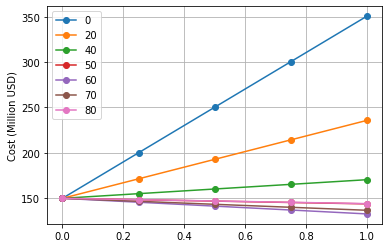

In [59]:
cost = pd.DataFrame(mAbs_cost).mean() + pd.DataFrame(hosp_cost).mean()
(cost.unstack() / 1_000_000).plot(marker='o')
plt.ylabel('Cost (Million USD)')
plt.grid();

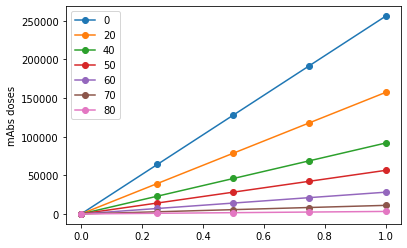

In [60]:
pd.DataFrame(doses).mean().unstack().plot(marker='o')
# plt.semilogy()
plt.ylabel('mAbs doses');

# Burden Averted

In [84]:
def averted(x):
    df = pd.Series({i: pd.DataFrame(x[i]).mean().sum() for i in x}).unstack()
    df_averted = df.loc[0, 0] - df
    return df_averted

In [85]:
c,a = .5, 50
sub = pd.DataFrame(n_COVID[0, 0]).mean().sum() - pd.DataFrame(n_COVID[c, a]).mean().sum()
sub
2517.839162810582


2517.839162810582

In [88]:
(pd.DataFrame(n_COVID[0, 0]) - pd.DataFrame(n_COVID[c, a]))

0          1          2          3   \
[0, 10)   male   White      0.000000   0.000000   0.000000   0.000000   
                 Black      0.000000   0.000000   0.000000   0.000000   
                 Hispanic   0.000000   0.000000   0.000000   0.000000   
                 Other      0.000000   0.000000   0.000000   0.000000   
          female White      0.000000   0.000000   0.000000   0.000000   
...                              ...        ...        ...        ...   
[80, 125) male   Other      4.525329   5.439024   3.762009   5.253956   
          female White     36.103078  35.188339  25.268585  50.951817   
                 Black     15.608927  10.908135   8.003600  12.925965   
                 Hispanic  12.974255  10.006487   7.845322   7.824936   
                 Other     10.895061   6.848344   4.715371   9.296188   

                                  4          5          6          7   \
[0, 10)   male   White      0.000000   0.000000   0.000000   0.000000   
                 Black      0.000000   0.000000   0.000000   0.000000   
                 Hispanic   0.000000   0.000000   0.000000   0.000000   
                 Other      0.000000   0.000000   0.000000   0.000000   
          female White      0.000000   0.000000   0.000000   0.000000   
...                              ...        ...        ...        ...   
[80, 125) male   Other      4.654485   4.315285   7.430319   4.698073   
          female White     33.008829  26.775795  43.799557  20.530856   
                 Black     14.705639  13.312600  15.588855   8.062738   
                 Hispanic  11.226249   8.406379  10.173196   4.771306   
                 Other      8.382526   5.234003   9.191888   3.096938   

                                  8          9   ...         90         91  \
[0, 10)   male   White      0.000000   0.000000  ...   0.000000   0.000000   
                 Black      0.000000   0.000000  ...   0.000000   0.000000   
                 Hispanic   0.000000   0.000000  ...   0.000000   0.000000   
                 Other      0.000000   0.000000  ...   0.000000   0.000000   
          female White      0.000000   0.000000  ...   0.000000   0.000000   
...                              ...        ...  ...        ...        ...   
[80, 125) male   Other      5.926250   4.903050  ...   2.853159   4.131047   
          female White     47.351556  45.107860  ...  25.452144  38.621479   
                 Black     14.097336  11.351251  ...   9.245900  15.749405   
                 Hispanic   5.620841   9.169314  ...   5.983813   9.382983   
                 Other      7.539138   6.582331  ...   5.411163   7.647391   

                                  92         93         94         95  \
[0, 10)   male   White      0.000000   0.000000   0.000000   0.000000   
                 Black      0.000000   0.000000   0.000000   0.000000   
                 Hispanic   0.000000   0.000000   0.000000   0.000000   
                 Other      0.000000   0.000000   0.000000   0.000000   
          female White      0.000000   0.000000   0.000000   0.000000   
...                              ...        ...        ...        ...   
[80, 125) male   Other      3.362769   8.332697   4.847564   2.985456   
          female White     33.082261  39.969309  41.669761  29.675512   
                 Black     10.400021  19.282865  18.164156  10.141524   
                 Hispanic   9.010213  11.718117   9.775058   4.114438   
                 Other      6.722134   8.810047   9.400702   3.480232   

                                  96         97         98         99  
[0, 10)   male   White      0.000000   0.000000   0.000000   0.000000  
                 Black      0.000000   0.000000   0.000000   0.000000  
                 Hispanic   0.000000   0.000000   0.000000   0.000000  
                 Other      0.000000   0.000000   0.000000   0.000000  
          female White      0.000000   0.000000   0.000000   0.000000  
...                              .

In [89]:
(pd.DataFrame(n_COVID[0, 0]) - pd.DataFrame(n_COVID[c, a])).sum()

0     2432.032456
1     1887.101942
2     1443.282878
3     2477.514133
4     1873.614618
         ...     
95    1436.904072
96    2017.363257
97    2063.704544
98    2054.249006
99    2062.671847
Length: 100, dtype: float64

In [90]:
(pd.DataFrame(n_COVID[0, 0]) - pd.DataFrame(n_COVID[c, a])).sum().mean()

1812.8441972236196

In [91]:
c,a

(0.5, 50)

In [86]:
c,a = .5, 50
sub = (pd.DataFrame(n_COVID[0, 0]) - pd.DataFrame(n_COVID[c, a])).mean().sum()
sub

2517.8391628105833

In [87]:
symptomatic_infections_averted = averted(n_COVID)
np.round(symptomatic_infections_averted, 1)

,0,20,40,50,60,70,80
0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.25,5713.5,3511.1,2048.0,1258.9,627.3,247.0,71.9
0.50,11427.1,7022.3,4096.0,2517.8,1254.5,494.0,143.8
0.75,17140.6,10533.4,6144.0,3776.8,1881.8,741.0,215.7
1.00,22854.2,14044.5,8192.0,5035.7,2509.1,988.0,287.6


In [65]:
c,a = 0.5, 50
(n_COVID[0,0][0] - n_COVID[c,a][0]).sum()

[0, 10)    male    White        0.000000
                   Black        0.000000
                   Hispanic     0.000000
                   Other        0.000000
           female  White        0.000000
                                 ...    
[80, 125)  male    Other        4.525329
           female  White       36.103078
                   Black       15.608927
                   Hispanic    12.974255
                   Other       10.895061
Length: 72, dtype: float64

In [70]:
(pd.DataFrame(n_COVID[0, 0]) - pd.DataFrame(n_COVID[c, a])).sum().describe()

count     100.000000
mean     1812.844197
std       341.661741
min      1108.139522
25%      1557.878922
50%      1858.098723
75%      2042.908742
max      2711.526206
dtype: float64

In [69]:
c,a = 0.5, 50
sub = pd.DataFrame(n_COVID[0, 0]) - pd.DataFrame(n_COVID[c, a])
np.percentile(sub.sum(), [2.5, 97.5])

array([1171.10377654, 2455.91033654])

In [71]:
np.mean(sub.sum())

1812.8441972236196

In [ ]:
hospitalizations_averted = averted(n_hosp)
np.round(hospitalizations_averted, 1)

In [ ]:
deaths_averted = averted(n_deaths)
np.round(deaths_averted, 1)

In [ ]:
np.round(pd.DataFrame({'symptomatic_infections_averted':symptomatic_infections_averted.stack(),
              'hospitalizations_averted':hospitalizations_averted.stack(),
              'deaths_averted':deaths_averted.stack(),
#               'mAbs_cost':pd.Series(mAbs_cost)/1e6,
#               'hosp_cost':pd.Series(hosp_cost)/1e6,
#               'total_cost':cost/1e6,
              'thousand_doses':pd.DataFrame(doses).mean()/1e3,
              'incremental_cost':(cost-cost.loc[0,0])/1e6
             }).unstack(level=0), 1)


In [ ]:
ICER = (cost-cost.loc[0,0]) / (deaths_averted).stack()
np.round((ICER / 1_000).unstack(), 1)

In [ ]:
(ICER / 1_000).unstack().T.iloc[:,-1].plot(marker='o')
plt.ylabel('ICER (Thousand USD per death averted)')
plt.xlabel('Minimum age for PEP (years)')
# plt.semilogy();

# PEP with mAbs is a benefit for patients and for hospitals

In [ ]:
def summary_results(coverage_level, age_lower_bound):
    n_symp_averted = symptomatic_infections_averted.loc[coverage_level, age_lower_bound]
    n_hosp_averted = hospitalizations_averted.loc[coverage_level, age_lower_bound]
    n_deaths_averted = deaths_averted.loc[coverage_level, age_lower_bound]
    unit_cost = mAbs_unit_cost
    incremental_cost = (cost.loc[coverage_level, age_lower_bound]-cost.loc[0,0])/1e6

    
    result_str = f"""Results: In a month of similar intensity to May, 2021,
    in USA, a program reaching {coverage_level*100:.0f}% of exposed household members
    aged {age_lower_bound}+, would avert {n_symp_averted:,.0f} symptomatic infections,
    {n_hosp_averted:,.0f} hospitalizations, and {n_deaths_averted:,.0f} deaths.  If the
    unit cost of administering the intervention was {pd.Series(unit_cost).mean():,.0f} dollars,
    this program would save the health system {-incremental_cost*1_000:,.0f} thousand dollars."""
    
    print(result_str)
summary_results(1/2, 50)

In [ ]:
# summary_results(1/3, 50)

In [ ]:
# summary_results(1/2, 50)

# Number-plugging values

In [ ]:
print(f"""[[summary of data: RCT included X subjects (Y in treatment group and Z in control),
which we combined with confirmed cases data on {len(df_cdc_month):,.0f} individuals and
household structure data derived from {len(acs):,.0f} individuals in {acs.household_id.nunique():,.0f} households.]]
""")

In [ ]:
n_2 = pd.DataFrame(n_2_unvax)
n_2

In [ ]:
print(f"""[[Confirmed case and household structure results,
summarizing something about the racial segregation of household structure,
the age-assortativity. In [[May]], there were [[{len(df_cdc_month):,.0f}]]
confirmed cases of COVID-19, which we estimate resulted
in {n_2.sum().mean():,.0f} (95% UI {np.percentile(n_2.sum(), 2.5):,.0f}-{np.percentile(n_2.sum(), 97.5):,.0f}) individuals with household exposure to COVID-19. ]] [[stratify counts or rates by race??]]""")

In [ ]:
n_2.unstack().sum().unstack().mean()

In [ ]:
print(f"""[[Number who receive PEP in alternative scenarios, and for alternative age cutoffs. Perhaps in a table?  Population-level rates of treatment stratified by race?]]""")

In [ ]:
def my_summary(x):
    mean = np.mean(x)
    lb = np.percentile(x, 2.5)
    ub = np.percentile(x, 97.5)
    results = locals()
    results.pop('x')
    for k in results:
        results[k] = '{:,.0f}'.format(results[k])
    results['ui'] = results['lb']+'-'+results['ub']
    results['mean_and_ui'] = f"""{results['mean']} (95% UI {results['ui']})"""
    return results

total_PEP = {}
for c,a in n_PEP.keys():
    total_PEP[c,a] = my_summary(pd.DataFrame(n_PEP[c,a]).sum())

In [ ]:
print(f"""In a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
we estimate {total_PEP[.5,50]['mean_and_ui']} individuals would be treated.""")

In [ ]:
print(f"""While in a hypothetical scenario where 50% of those exposed and of age 80 or older receive PEP,
we estimate {total_PEP[.5,80]['mean']} (95% UI {total_PEP[.5,80]['ui']}) individuals would be treated,""")

In [ ]:
print(f"""and in a hypothetical scenario where 50% of those exposed and of age 20 or older receive PEP,
we estimate {total_PEP[.5,20]['mean']} (95% UI {total_PEP[.5,20]['ui']}) individuals would be treated.""")

In [ ]:
total_COVID = {}
for c,a in n_COVID.keys():
    total_COVID[c,a] = my_summary(pd.DataFrame(n_COVID[c,a]).sum())

In [ ]:
print(f"""[[Number who develop symptomatic COVID-19 in baseline and alternative scenarios, and for alternative age cutoffs. Including stratification by race and ethnicity.]]""")

print(f"""We estimate that without PEP, {total_COVID[0,0]['mean_and_ui']} individuals developed a symptomatic COVID-19 infection from a household exposure,
      while in a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
{total_COVID[.5,50]['mean_and_ui']} individuals developed a symptomatic infection.""")

In [ ]:
print(f"""In a hypothetical scenario where 50% of those exposed and of age 80 or older receive PEP,
we estimate {total_COVID[.5,80]['mean_and_ui']} individuals developed symptomatic infection,
and in a hypothetical scenario where 50% of those exposed and of age 20 or older receive PEP,
we estimate {total_COVID[.5,20]['mean_and_ui']} individuals developed symptomatic infection.""")

In [ ]:
total_hosp = {}
for c,a in n_hosp.keys():
    total_hosp[c,a] = my_summary(pd.DataFrame(n_hosp[c,a]).sum())
total_deaths = {}
for c,a in n_deaths.keys():
    total_deaths[c,a] = my_summary(pd.DataFrame(n_deaths[c,a]).sum())

In [ ]:
print(f"""We estimate that without PEP, {total_hosp[0,0]['mean_and_ui']} individuals would be hospitalized
because of a COVID-19 infection from a household exposure,
while in a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
{total_hosp[.5,50]['mean_and_ui']} individuals would be hospitalized;
in a scenario where 50% of those exposed and of age 80 or older receive PEP,
we estimate {total_hosp[.5,80]['mean_and_ui']} individuals would be hospitalized,
and in a scenario where 50% of those exposed and of age 20 or older receive PEP,
{total_hosp[.5,20]['mean_and_ui']} individuals would be hospitalized.
""")

In [ ]:
print(f"""We estimate that without PEP, {total_deaths[0,0]['mean_and_ui']} individuals would die
because of a COVID-19 infection from a household exposure,
while in a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
{total_deaths[.5,50]['mean_and_ui']} individuals would die;
in a scenario where 50% of those exposed and of age 80 or older receive PEP,
{total_deaths[.5,80]['mean_and_ui']} individuals would die,
and in a scenario where 50% of those exposed and of age 20 or older receive PEP,
{total_deaths[.5,20]['mean_and_ui']} individuals would die.
""")

In [ ]:
total_cost = {}
hosp_cost_str = {}
PEP_cost = {}
savings = {}
incremental_cost = {}

total_cost_0 = (pd.Series(mAbs_cost[0,0]) + pd.Series(hosp_cost[0,0])) / 1_000_000

for c,a in n_hosp.keys():
    total_cost_ca = (pd.Series(mAbs_cost[c,a]) + pd.Series(hosp_cost[c,a])) / 1_000_000
    total_cost[c,a] = my_summary(total_cost_ca)
    savings[c,a] = my_summary(total_cost_0 - total_cost_ca)
    incremental_cost[c,a] = my_summary(total_cost_ca - total_cost_0)
    hosp_cost_str[c,a] = my_summary(pd.Series(hosp_cost[c,a])/1_000_000)
    PEP_cost[c,a] = my_summary(pd.Series(mAbs_cost[c,a])/1_000_000)
    

In [ ]:
print(f"""We estimate that without PEP, the cost of hospitalizations due to COVID-19 infections from
household exposure would be {hosp_cost_str[0,0]['mean_and_ui']} million dollars,
while in a hypothetical scenario where 50% of those exposed and of age 50 or older receive PEP,
the cost of hospitalizations would be {hosp_cost_str[.5,50]['mean_and_ui']} million dollars and
the cost of PEP would be {PEP_cost[.5,50]['mean_and_ui']} million dollars,
for a total of {total_cost[.5,50]['mean_and_ui']} million dollars,
which is a savings of {savings[.5,50]['mean_and_ui']} million dollars compared to the without-PEP scenario.
In a hypothetical scenario where 50% of those exposed and of age 80 or older receive PEP,
the cost of hospitalizations would be {hosp_cost_str[.5,80]['mean_and_ui']} million dollars and
the cost of PEP would be {PEP_cost[.5,80]['mean_and_ui']} million dollars,
for a total of {total_cost[.5,80]['mean_and_ui']} million dollars,
which is a savings of {savings[.5,80]['mean_and_ui']} million dollars compared to the without-PEP scenario;
and in a hypothetical scenario where 50% of those exposed and of age 20 or older receive PEP,
the cost of hospitalizations would be {hosp_cost_str[.5,20]['mean_and_ui']} million dollars and
the cost of PEP would be {PEP_cost[.5,20]['mean_and_ui']} million dollars,
for a total of {total_cost[.5,20]['mean_and_ui']} million dollars,
which is a total of {incremental_cost[.5,20]['mean_and_ui']} million dollars more than in the without-PEP scenario.
""")

In [ ]:
total_cost[c,a]

In [ ]:
import seaborn as sns

In [ ]:
plt.figure(figsize=(6.5,3), dpi=120)
for c in [0.25, .5, .75]:
    for i, a in enumerate(age_lower_bounds[::-1]):
        s_cost = (pd.Series(mAbs_cost[c,a]) + pd.Series(hosp_cost[c,a])) / 1e6
        s_cost -= (pd.Series(mAbs_cost[0,0]) + pd.Series(hosp_cost[0,0])) / 1e6
        
        s_deaths = pd.DataFrame(n_deaths[c,a]).sum(axis=0)
        s_deaths -= pd.DataFrame(n_deaths[0,0]).sum(axis=0)
        s_deaths *= -1
        
        if c == 0.5:
            plt.plot(s_deaths, s_cost, 'o', label=f'{a}+', alpha=.95, color='none', mec=f'C{i}', mew=1)
#         else:
#             plt.plot(s_deaths, s_cost, 'o', color='grey')
plt.legend(loc=(1.02, .02), title='50% coverage, with\nPEP for exposed of age:')
plt.xlabel('COVID-19 deaths averted (people)')
plt.ylabel('Incremental cost (millions of dollars)')
plt.grid()
plt.subplots_adjust(right=.7);

In [ ]:
attack_rate_without_mAbs.shape